In [2]:
import os 
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100


Ваша последняя лабораторная работа будет заключаться в реализации одного из двух алгоритмов, <br>подсказанных природой, для решении задачи vehicle routing problem:

1) Алгоритм колонии муравьев
2) Алгоритм колонии пчел

Данные:

Прикрепил в архиве. Формат такой:<br>
1-6 строчки - доп. информация про бенчмарку, No of trucks - количество грузовиков, CAPACITY - вместимость грузовика.<br>
7 строчка NODE_COORD_SECTION - начало данных про пункты<br>
1 17 36 - 1 пункт, координата по x - 17, координата по y - 36<br>
...<br>
Строчка DEMAND_SECTION - начало информации про требуемое количество материала для пункта<br>
7 9 - 7 пункт, 9 - требуемое количество материала. Если требуется 0 - этот пункт склад.<br>

Формат выходных данных, которые нужно выслать по каждой бенчмарке - приложил как файл B-n78-k10.sol в архиве.<br>

Форма отчетности:<br>

Вы присылаете мне код алгоритма и файлы с ответами. Работать можно в группах не более 3-х человек. Прогнать нужно на <br>всех данных. Код и ответы можно прислать мне на почту (epburashnikov@hse.ru). В теме письма укажите: "АИО Лаб. 5 <br>Имя Фамилия", где вместо Имя Фамилия укажите ваши реальные Имя и Фамилию, например, АИО Лаб. 5 Ян Лекун.<br>

Дедлайн: 07.06.2020 23:59<br>

In [94]:
from utils import tools
tools = imp.reload(tools)

In [582]:
problem = tools.get_problem('benchmarks/A/A-n32-k5.vrp')

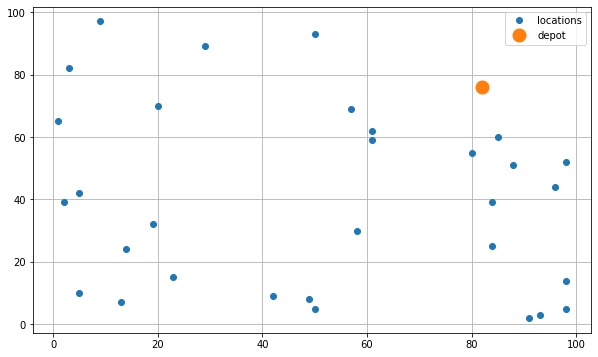

In [583]:
tools = imp.reload(tools)
tools.visualize_problem(problem)

In [ ]:
tools = imp.reload(tools)
solution  = tools.generate_solution(problem, patience=10000)
solution

In [585]:
sol_cost = tools.compute_solution(problem, solution)
sol_cost

2172.1106

In [ ]:
from algorithm import local_search
local_search = imp.reload(local_search)

alg = local_search.LocalSearch(problem)
alg.set_params(solution, n_iter=1000)
new_sol, new_cost = alg.solve(verbose=True)

In [589]:
new_cost = tools.compute_solution(problem, new_sol)
print('Alg cost {}'.format(new_cost))
print('Optimal cost {}'.format(problem['optimal']))
new_sol

Alg cost 1385.3768310546875
Optimal cost 784


array([ 0, 14, 18,  4, 10, 16, 21,  7,  0,  5, 29, 25, 22, 11,  9, 15,  0,
       27, 13, 17, 24,  0, 30, 23,  2, 28,  8, 20,  0,  1,  6,  3, 31, 19,
       12, 26,  0])

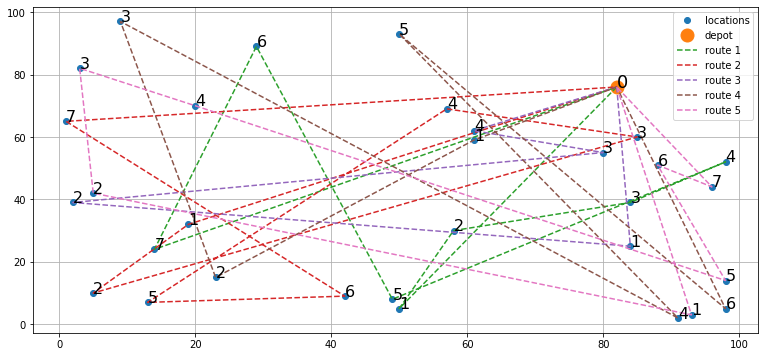

In [590]:
tools.visualize_problem(problem, solution, figsize=(13,6))

array([ 0, 14, 18,  4, 10, 16, 21,  7,  0,  5, 29, 25, 22, 11,  9, 15,  0,
       27, 13, 17, 24,  0, 30, 23,  2, 28,  8, 20,  0,  1,  6,  3, 31, 19,
       12, 26,  0])

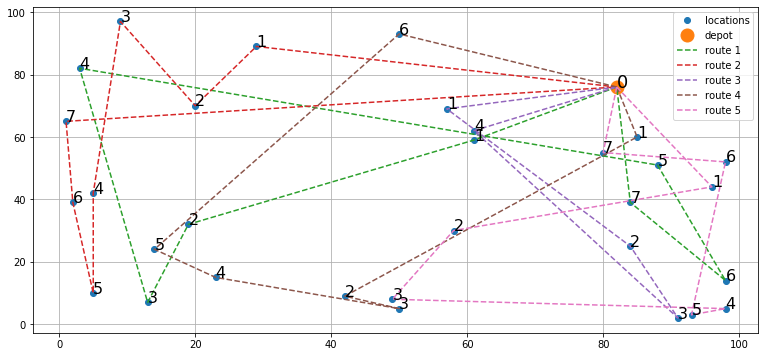

In [591]:
tools.visualize_problem(problem, new_sol, figsize=(13,6))
new_sol